In [2]:
import pandas as pd 
import numpy as np
import lightgbm as lgb
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score


plt.rcParams["figure.figsize"] = (14,8)
warnings.filterwarnings("ignore")

In [3]:
loas_dataset = pd.read_csv('loan_predictions.csv')

<ul>
    <li>Empréstimo_ID	ID de empréstimo exclusivo</li>
    <li>Gênero	Masculino feminino</li>
    <li>Casado	Requerente casado (S/N)</li>
    <li>Dependentes	Número de dependentes</li>
    <li>Educação	Educação do candidato (Graduação/Graduação)</li>
    <li>Trabalhadores por conta própria	Autônomo (S/N)</li>
    <li>Renda do Candidato	Renda do solicitante</li>
    <li>Renda do requerente	Renda do co-requerente</li>
    <li>Montante do empréstimo	Valor do empréstimo em milhares</li>
    <li>Empréstimo_Valor_Prazo	Prazo do empréstimo em meses</li>
    <li>Histórico de crédito	histórico de crédito atende às diretrizes</li>
    <li>Propriedade_Área	Urbano/Semiurbano/Rural</li>
    <li>Empréstimo_Status	(Meta) Empréstimo aprovado (S/N)</li>
</ul>

# Visao geral inicial

Essa base trata-se de dados de emprestimo, que possivelmente foi tomada as decisões manualmente, teve uma pessoa ou uma equipe que analisou caso por caso e decidiu se iria dar ou nao o emprestimo, o nosso objetivo como cientista de dados é automatizar esse processo de aprovação ou reprovação de emprestimos, acredito que seria interessante ter mais um status chamado "derivar" que seria casos em que nao é recomendado um modelo decidir, altos valores por exemplo ou ate mesmo casos em que o modelo tenha 50% de probabilidade... No mundo real seria interessante delimitar regras iniciais como, a previsão do modelo deve ter 70% ou mais de probabilidade de ser N ou Y, caso contrato iria derivar para a mesa de analistas. Inicialmente são coisas que eu pensaria antes mesmo de criar um modelo, apesar de, num mundo ideal seria tudo automatizado, na realizade nao é bem assim, temos que tentar tirar o maximo de trabalho de nossos analistas e faze-los focar em casos em que a habilidade e experiencia de negocio fale mais alto.

# Atalhos

Como é uma base relativamente pequena, irei abri-la no excel para observar coisas como quantidade de variaveis entre outros, caso fosse uma base extremamente grande e robusta, usaria o pandas ou ate mesmo o spark para fazer o processamento de dados, mas como queremos agilizade, o excel me parece uma boa ferramenta para esse caso

# Sugestão

trazer a idade de cada solicitante, iria ajudar no algoritmo

In [4]:
loas_dataset.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
loas_dataset

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


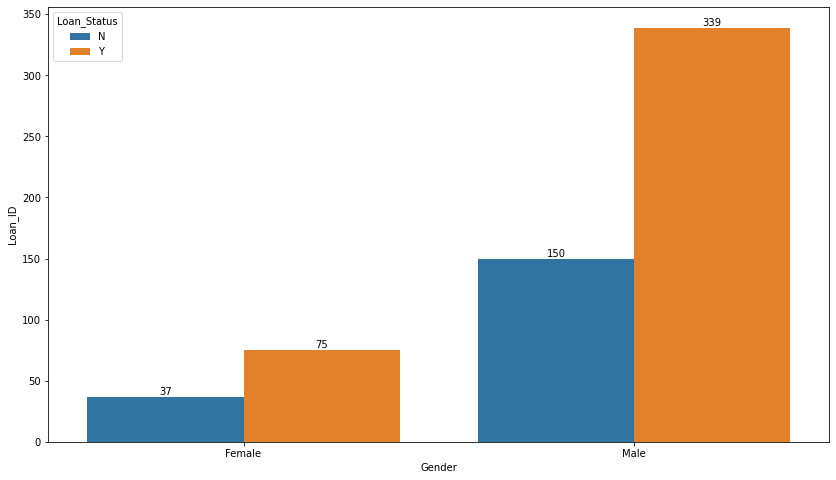

Loan_ID
Gender Loan_Status          
Female N            0.330357
       Y            0.669643
Male   N            0.306748
       Y            0.693252

In [6]:
genero_target_count = loas_dataset[['Loan_Status', 'Gender', 'Loan_ID']].groupby(['Loan_Status', 'Gender']).count().reset_index()
ax = sns.barplot(data=genero_target_count, x='Gender', y='Loan_ID', hue='Loan_Status')
# Loop to add on each bar a tag in position
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom')
plt.show()
display(loas_dataset[['Loan_Status', 'Gender', 'Loan_ID']].groupby(['Gender', 'Loan_Status']).count()/loas_dataset[['Gender', 'Loan_ID']].groupby(['Gender']).count())

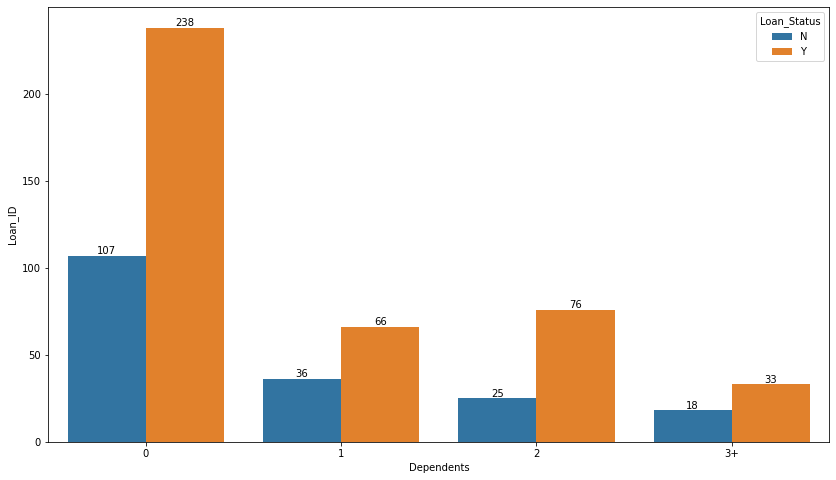

Loan_ID
Dependents Loan_Status          
0          N            0.310145
           Y            0.689855
1          N            0.352941
           Y            0.647059
2          N            0.247525
           Y            0.752475
3+         N            0.352941
           Y            0.647059

In [7]:
dependents_target_count = loas_dataset[['Loan_Status', 'Dependents', 'Loan_ID']].groupby(['Loan_Status', 'Dependents']).count().reset_index()
ax = sns.barplot(data=dependents_target_count, x='Dependents', y='Loan_ID', hue='Loan_Status')
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom')

plt.show()
display(loas_dataset[['Loan_Status', 'Dependents', 'Loan_ID']].groupby(['Dependents', 'Loan_Status']).count()/loas_dataset[['Dependents', 'Loan_ID']].groupby(['Dependents']).count())

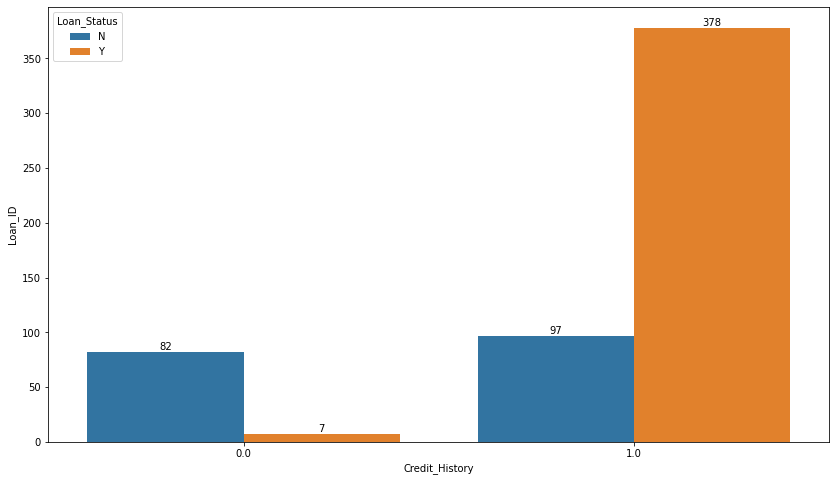

Loan_ID
Credit_History Loan_Status          
0.0            N            0.921348
               Y            0.078652
1.0            N            0.204211
               Y            0.795789

In [8]:
genero_target_count = loas_dataset[['Loan_Status', 'Credit_History', 'Loan_ID']].groupby(['Loan_Status', 'Credit_History']).count().reset_index()
ax = sns.barplot(data=genero_target_count, x='Credit_History', y='Loan_ID', hue='Loan_Status')

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom')

plt.show()
display(loas_dataset[['Loan_Status', 'Credit_History', 'Loan_ID']].groupby(['Credit_History', 'Loan_Status']).count()/loas_dataset[['Credit_History', 'Loan_ID']].groupby(['Credit_History']).count())

In [9]:
from sklearn.impute import SimpleImputer

In [10]:
imputador_categorico = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imputador_numerico = SimpleImputer(strategy='median', missing_values=np.nan)

In [11]:
loas_dataset['Credit_History'] = loas_dataset['Credit_History'].astype('object')

In [12]:
categoticos = loas_dataset.select_dtypes(include=['object']).fillna(np.nan)
numerais    = loas_dataset.select_dtypes(exclude=['object']).fillna(np.nan)

In [13]:
numerais = pd.DataFrame(imputador_numerico.fit_transform(numerais), columns = numerais.columns)
categoticos = pd.DataFrame(imputador_categorico.fit_transform(categoticos), columns = categoticos.columns)

loas_dataset_tratada = pd.concat((numerais, categoticos), axis=1)

In [14]:
loas_dataset_tratada['vl_parcela_mensal'] = loas_dataset_tratada['LoanAmount']*1000/loas_dataset_tratada['Loan_Amount_Term']
loas_dataset_tratada['salario_total'] = loas_dataset_tratada['ApplicantIncome'] + loas_dataset_tratada['CoapplicantIncome']
loas_dataset_tratada['percentual_salario'] = loas_dataset_tratada['vl_parcela_mensal']/loas_dataset_tratada['salario_total']

In [15]:
loas_dataset_tratada['percentual_salario'].describe()

count    614.000000
mean       0.077391
std        0.079017
min        0.007008
25%        0.055302
50%        0.068970
75%        0.081695
max        1.236873
Name: percentual_salario, dtype: float64

In [16]:
loas_dataset_tratada.sort_values(by='percentual_salario', ascending=False)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,vl_parcela_mensal,salario_total,percentual_salario
262,3481.0,0.0,155.0,36.0,LP001870,Female,No,1,Graduate,No,1.0,Semiurban,N,4305.555556,3481.0,1.236873
497,4625.0,2857.0,111.0,12.0,LP002588,Male,Yes,0,Graduate,No,1.0,Urban,Y,9250.000000,7482.0,1.236300
546,3358.0,0.0,80.0,36.0,LP002768,Male,No,0,Not Graduate,No,1.0,Semiurban,N,2222.222222,3358.0,0.661770
575,3159.0,461.0,108.0,84.0,LP002868,Male,Yes,2,Graduate,No,1.0,Urban,Y,1285.714286,3620.0,0.355170
313,5746.0,0.0,144.0,84.0,LP002008,Male,Yes,2,Graduate,Yes,1.0,Rural,Y,1714.285714,5746.0,0.298344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,2378.0,0.0,9.0,360.0,LP002840,Female,No,0,Graduate,No,1.0,Urban,N,25.000000,2378.0,0.010513
370,15759.0,0.0,55.0,360.0,LP002194,Female,No,0,Graduate,Yes,1.0,Semiurban,Y,152.777778,15759.0,0.009695
509,13262.0,0.0,40.0,360.0,LP002634,Female,No,1,Graduate,No,1.0,Urban,Y,111.111111,13262.0,0.008378
185,39147.0,4750.0,120.0,360.0,LP001640,Male,Yes,0,Graduate,Yes,1.0,Semiurban,Y,333.333333,43897.0,0.007594


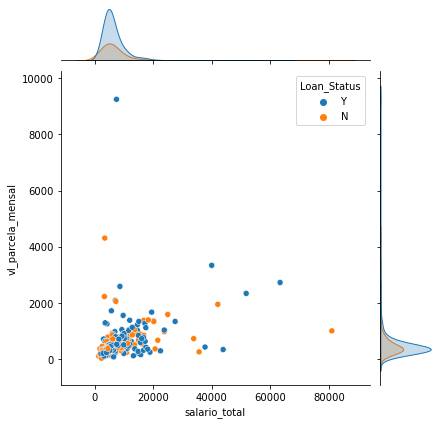

In [17]:
sns.jointplot(data = loas_dataset_tratada, y='vl_parcela_mensal', x='salario_total', hue='Loan_Status')

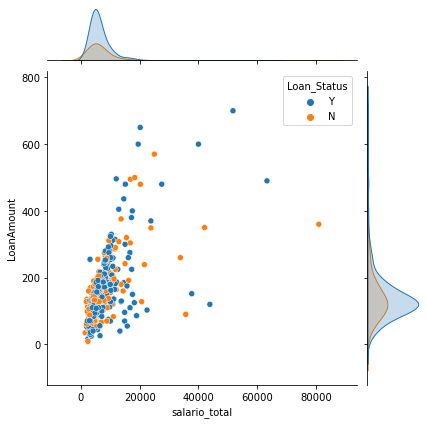

In [18]:
sns.jointplot(data = loas_dataset_tratada, y='LoanAmount', x='salario_total', hue='Loan_Status')

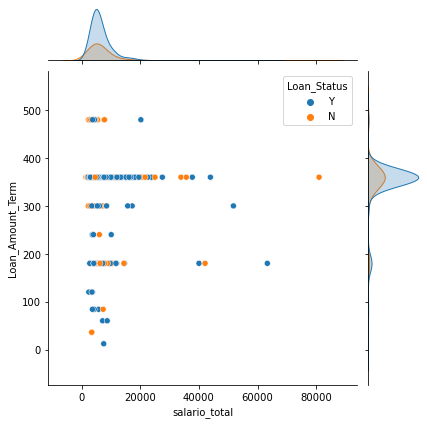

In [19]:
sns.jointplot(data = loas_dataset_tratada, y='Loan_Amount_Term', x='salario_total', hue='Loan_Status')

<AxesSubplot:xlabel='Credit_History', ylabel='Density'>

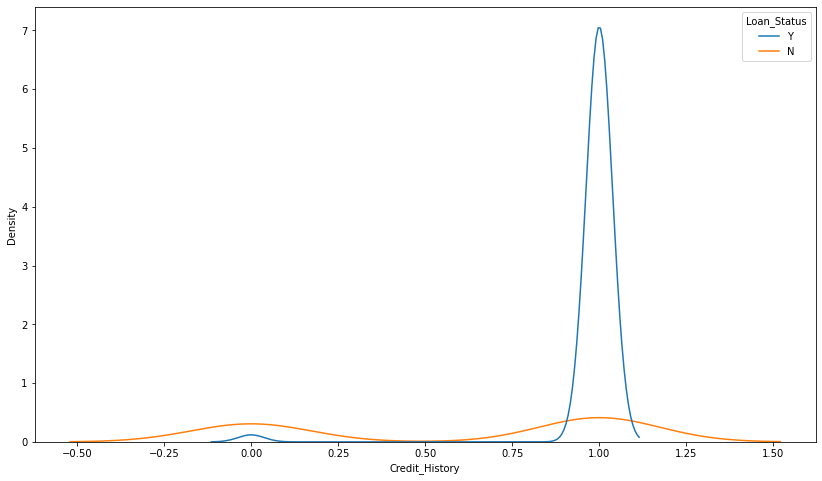

In [20]:
sns.kdeplot(data = loas_dataset_tratada, x="Credit_History", hue="Loan_Status")

<AxesSubplot:xlabel='Credit_History', ylabel='Count'>

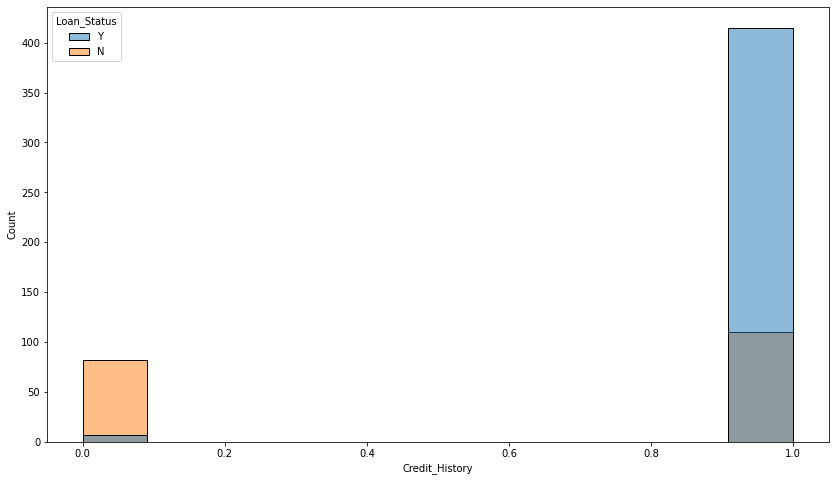

In [21]:
sns.histplot(data = loas_dataset_tratada, x="Credit_History", hue="Loan_Status", )

<AxesSubplot:xlabel='percentual_salario', ylabel='Density'>

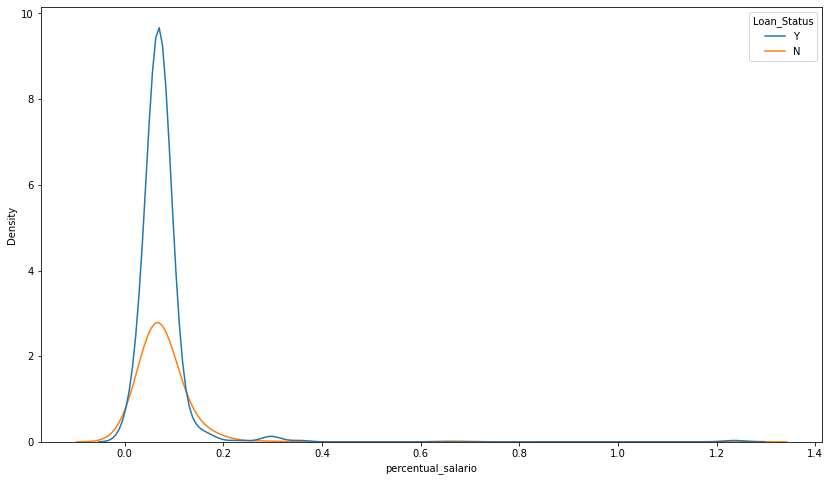

In [22]:
sns.kdeplot(data = loas_dataset_tratada, x="percentual_salario", hue="Loan_Status")

<AxesSubplot:>

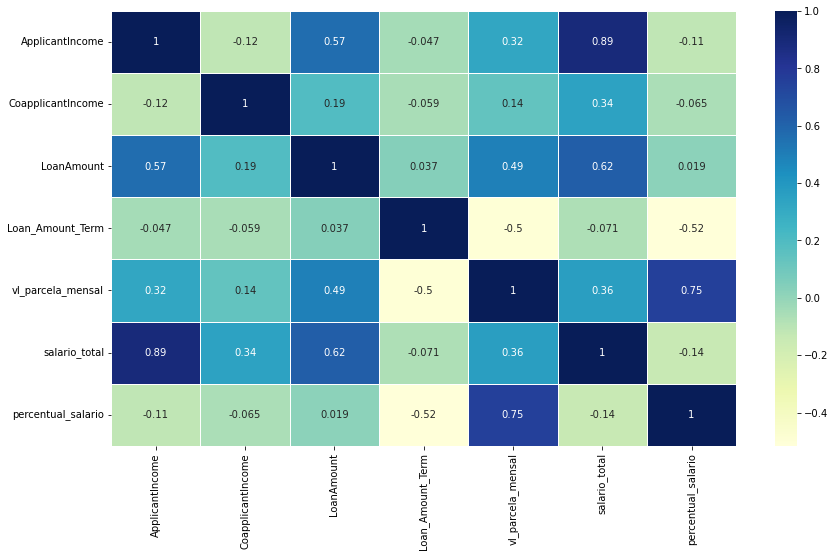

In [23]:
sns.heatmap(loas_dataset_tratada.corr(), annot=True, linewidths=.5, cmap="YlGnBu")

In [24]:
loas_dataset_tratada

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,vl_parcela_mensal,salario_total,percentual_salario
0,5849.0,0.0,128.0,360.0,LP001002,Male,No,0,Graduate,No,1.0,Urban,Y,355.555556,5849.0,0.060789
1,4583.0,1508.0,128.0,360.0,LP001003,Male,Yes,1,Graduate,No,1.0,Rural,N,355.555556,6091.0,0.058374
2,3000.0,0.0,66.0,360.0,LP001005,Male,Yes,0,Graduate,Yes,1.0,Urban,Y,183.333333,3000.0,0.061111
3,2583.0,2358.0,120.0,360.0,LP001006,Male,Yes,0,Not Graduate,No,1.0,Urban,Y,333.333333,4941.0,0.067463
4,6000.0,0.0,141.0,360.0,LP001008,Male,No,0,Graduate,No,1.0,Urban,Y,391.666667,6000.0,0.065278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900.0,0.0,71.0,360.0,LP002978,Female,No,0,Graduate,No,1.0,Rural,Y,197.222222,2900.0,0.068008
610,4106.0,0.0,40.0,180.0,LP002979,Male,Yes,3+,Graduate,No,1.0,Rural,Y,222.222222,4106.0,0.054121
611,8072.0,240.0,253.0,360.0,LP002983,Male,Yes,1,Graduate,No,1.0,Urban,Y,702.777778,8312.0,0.084550
612,7583.0,0.0,187.0,360.0,LP002984,Male,Yes,2,Graduate,No,1.0,Urban,Y,519.444444,7583.0,0.068501


<AxesSubplot:xlabel='salario_total', ylabel='Gender'>

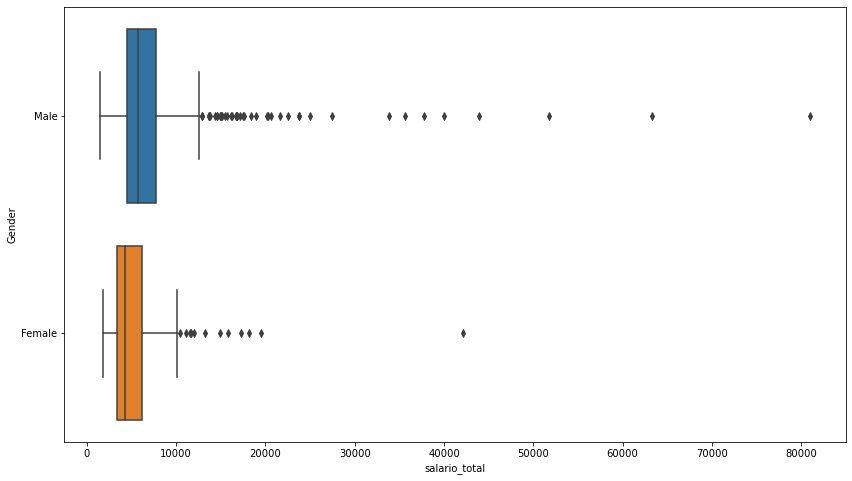

In [25]:
sns.boxplot(data = loas_dataset_tratada, x='salario_total', y='Gender')

<AxesSubplot:xlabel='salario_total', ylabel='Married'>

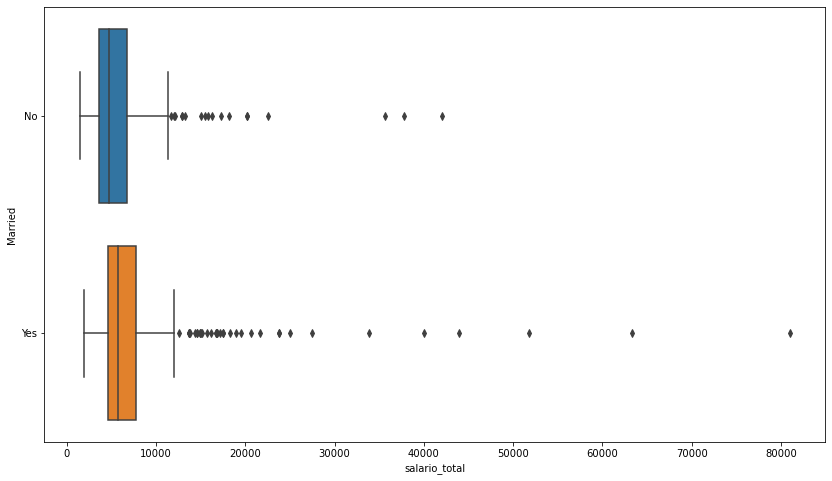

In [26]:
sns.boxplot(data = loas_dataset_tratada, x='salario_total', y='Married')

<AxesSubplot:xlabel='salario_total', ylabel='Education'>

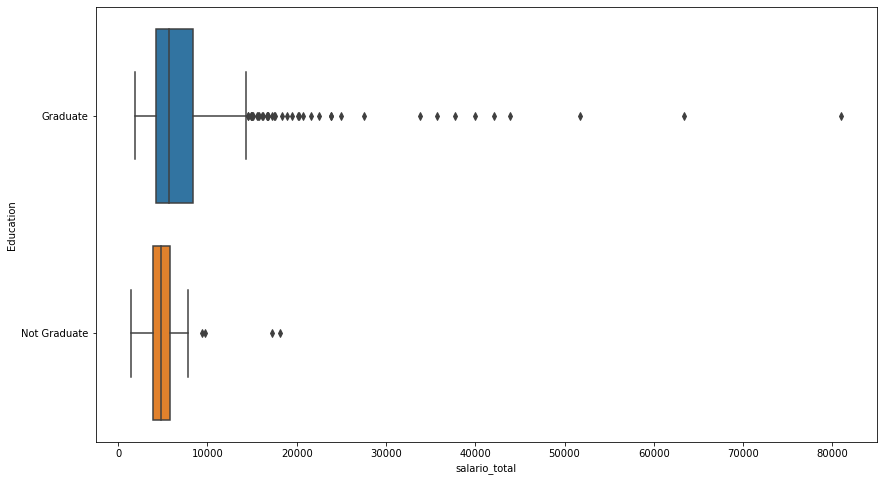

In [27]:
sns.boxplot(data = loas_dataset_tratada, x='salario_total', y='Education')

<AxesSubplot:xlabel='salario_total', ylabel='Property_Area'>

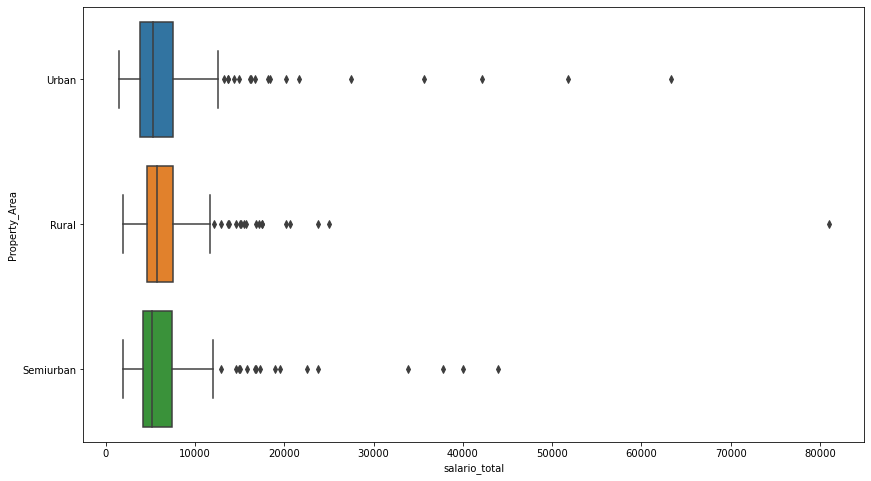

In [28]:
sns.boxplot(data = loas_dataset_tratada, x='salario_total', y='Property_Area')

<AxesSubplot:xlabel='salario_total', ylabel='Self_Employed'>

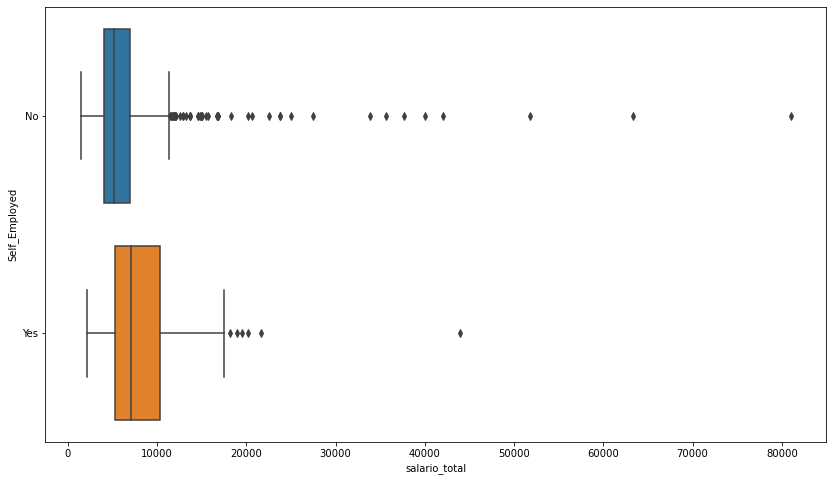

In [29]:
sns.boxplot(data = loas_dataset_tratada, x='salario_total', y='Self_Employed')

In [30]:
# sns.pairplot(loas_dataset_tratada, hue='Loan_Status')

In [31]:
loas_dataset_tratada['Credit_History'] = loas_dataset_tratada['Credit_History'].astype('string')

<AxesSubplot:xlabel='salario_total', ylabel='Credit_History'>

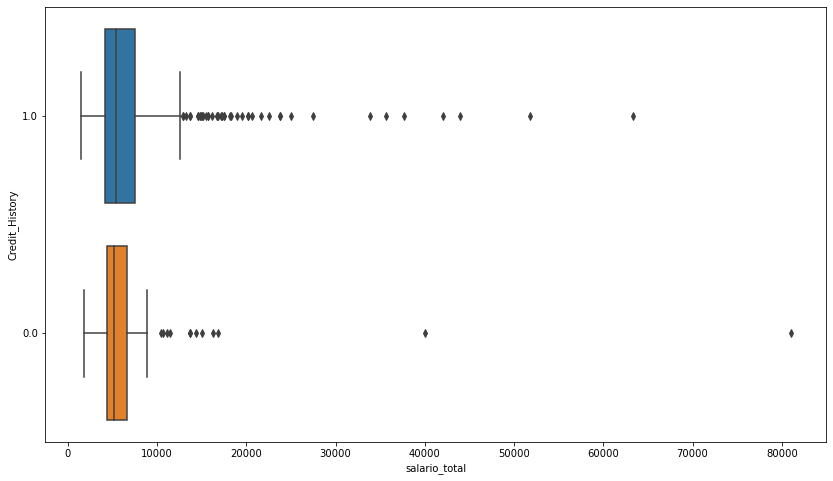

In [32]:
sns.boxplot(data = loas_dataset_tratada, x='salario_total', y='Credit_History')

<AxesSubplot:xlabel='CoapplicantIncome', ylabel='Credit_History'>

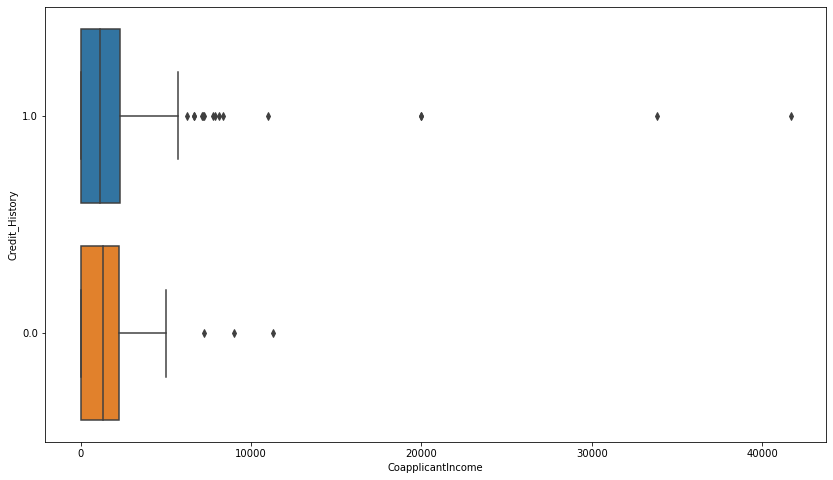

In [33]:
sns.boxplot(data = loas_dataset_tratada, x='CoapplicantIncome', y='Credit_History')

In [34]:
corte = np.quantile(loas_dataset_tratada['percentual_salario'].values, 0.99)

In [35]:
loas_dataset_tratada = loas_dataset_tratada[loas_dataset_tratada['percentual_salario'] <= corte]

In [36]:
loas_dataset_tratada['Loan_Status'].value_counts()/loas_dataset_tratada['Loan_Status'].count()

Y    0.686985
N    0.313015
Name: Loan_Status, dtype: float64

In [37]:
loas_dataset_tratada.drop(['salario_total', 'Loan_ID'], axis=1, inplace=True)

In [38]:
stardard = StandardScaler()

In [39]:
target = loas_dataset_tratada.pop('Loan_Status')

In [40]:
base_numerais = loas_dataset_tratada.drop(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area'], axis=1)

In [41]:
base_numerais = stardard.fit_transform(base_numerais)

In [42]:
base_numerais_normalizado = pd.DataFrame(base_numerais, columns=stardard.feature_names_in_)

In [43]:
base_categorica = pd.get_dummies(loas_dataset_tratada[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']], drop_first=True)

In [44]:
base_tratada = pd.concat((base_numerais_normalizado.reset_index(drop=True), base_categorica.reset_index(drop=True)), axis=1, verify_integrity=True)

In [45]:
x_train, x_validador, y_train, y_validador = train_test_split(base_tratada.values, target.values, random_state = 42, test_size = 0.2)

In [71]:
models = [LogisticRegressionCV(), RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), LinearSVC(), lgb.LGBMClassifier()]

for model in models:
    scores = cross_val_score(model, x_train, y_train, cv=KFold(5))
    print('modelo: ', model.__class__.__name__, ', scores: ', np.round(scores, 2), ', media: ', round(scores.mean(), 2))

modelo:  LogisticRegressionCV , scores:  [0.78 0.86 0.81 0.81 0.78] , media:  0.81
modelo:  RandomForestClassifier , scores:  [0.79 0.82 0.85 0.82 0.78] , media:  0.81
modelo:  AdaBoostClassifier , scores:  [0.79 0.84 0.74 0.76 0.78] , media:  0.78
modelo:  GradientBoostingClassifier , scores:  [0.75 0.85 0.77 0.78 0.75] , media:  0.78
modelo:  LinearSVC , scores:  [0.78 0.86 0.8  0.81 0.78] , media:  0.81
modelo:  LGBMClassifier , scores:  [0.77 0.81 0.8  0.77 0.79] , media:  0.79
